<a href="https://colab.research.google.com/github/C23-PS237/TaniKami-Machine-Learning-MobileNet/blob/main/%5BMobileNet%5DPlant_Disease_Classification_TaniKami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download and extract dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# ! pip install -q kaggle

In [ ]:
# ! mkdir ~/.kaggle

In [ ]:
# ! cp kaggle.json ~/.kaggle/

In [ ]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets list

In [ ]:
# !kaggle datasets download -d vipoooool/new-plant-diseases-dataset 

In [ ]:
!unzip -q /content/gdrive/MyDrive/new-plant-diseases-dataset.zip -d /content/

In [ ]:
# !kaggle datasets download -d nizorogbezuode/rice-leaf-images -d /content/gdrive/MyDrive

In [ ]:
!unzip -q /content/gdrive/MyDrive/rice-leaf-images.zip -d /content/

In [ ]:
# !rm /content/gdrive/MyDrive/Dataset3/rice-leaf-images.zip

In [ ]:
import numpy as np
import shutil
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model
import sklearn.metrics

In [ ]:
# Check if the files are complete
root_dir = "/content/rice_images"
train_file_list = os.listdir(root_dir)
num_samples = 0
for folder in train_file_list :
  dir = root_dir + "/" + folder
  dir_list = os.listdir(dir)
  num_samples += len(dir_list)
print(f"number of rice samples is : {num_samples}")

root_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
train_file_list = os.listdir(root_dir)
num_samples = 0
for folder in train_file_list :
  dir = root_dir + "/" + folder
  dir_list = os.listdir(dir)
  num_samples += len(dir_list)
print(f"number of train plant samples is : {num_samples}")

root_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
train_file_list = os.listdir(root_dir)
num_samples = 0
for folder in train_file_list :
  dir = root_dir + "/" + folder
  dir_list = os.listdir(dir)
  num_samples += len(dir_list)
print(f"number of val plant samples is : {num_samples}")

root_dir = "/content/test"
train_file_list = os.listdir(root_dir)
num_samples = 0
for folder in train_file_list :
  dir = root_dir + "/" + folder
  dir_list = os.listdir(dir)
  num_samples += len(dir_list)
print(f"number of test plant samples is : {num_samples}")

number of rice samples is : 3355
number of train plant samples is : 70295
number of val plant samples is : 17572
number of test plant samples is : 33


## Combining rice leaf dataset to the plant disease dataset

In [ ]:
# count the numbers of files in each rice folder 
rice_dir = '/content/rice_images'
rice_class = os.listdir(rice_dir) # list of class
rice_class_dir = []
for folder in rice_class:
  dir = rice_dir + '/' + folder
  rice_class_dir.append(dir) # list of class dir

num_class_rice =[]
for directory in rice_class_dir:
  listdir =  os.listdir(directory)
  num_class_rice.append(len(listdir)) # number of files in each class

In [ ]:
# Making a list of list , where each element is a list containing dir of files from a class
files_of_classes = []
for dir in rice_class_dir:
  files_in_dir = os.listdir(dir)
  full_paths =  [os.path.join(dir,file) for file in files_in_dir]
  files_of_classes.append(full_paths)

In [ ]:
# Make slices of each class for training, validation (testing set will be sliced by ImageDataGenerator)set
train_slice =[]
val_slice = []
test_slice = []
for folder in files_of_classes:
  num_train = int(len(folder)*0.7)
  # num_val = int(len(folder)*0.3) + num_train
  tr_slice = folder[:num_train]
  # vl_slice = folder[num_train:num_val]
  vl_slice = folder[num_train:]
  train_slice.append(tr_slice)
  val_slice.append(vl_slice)
  # test_slice.append(tst_slice)


In [ ]:
# Make the class names as new folders in our original train,val and test set
train_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
val_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"
for name in rice_class:
  new_train_dir = train_dir + "Rice_" + name
  new_val_dir = val_dir + "Rice_" + name
  os.mkdir(new_train_dir)
  os.mkdir(new_val_dir)

In [ ]:
# Move the sliced files to their corresponding folders  

for train_folder in train_slice:
  for files in train_folder:
    folder_name = files.split("/")[3] 
    destination_folder = train_dir + "Rice_" + folder_name + "/"
    shutil.move(files, destination_folder)

for val_folder in val_slice:
  for files in val_folder:
    folder_name = files.split("/")[3] 
    destination_folder = val_dir + "Rice_" + folder_name + "/"
    shutil.move(files, destination_folder)

## Preprocessing data

In [ ]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
batch_size = 32
epochs = 35
learning_rate = 0.001

In [ ]:
# train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
#                                                              shear_range=0.2,
#                                                              zoom_range=0.2,
#                                                              width_shift_range=0.2,
#                                                              height_shift_range=0.2,
#                                                              fill_mode="nearest")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                           validation_split = 0.2) 

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=target_size,
                                               batch_size=batch_size,
                                               shuffle =True,
                                               class_mode = "categorical"
                                               )
val_data = val_datagen.flow_from_directory(val_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             shuffle = False,
                                             class_mode = "categorical",
                                             subset = "training")

test_data = val_datagen.flow_from_directory(val_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             shuffle = False,
                                             class_mode = "categorical",
                                             subset = "validation")

Found 72642 images belonging to 42 classes.
Found 14877 images belonging to 42 classes.
Found 3703 images belonging to 42 classes.


In [ ]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)
print(categories)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Rice__BrownSpot': 24, 'Rice__Healthy': 25, 'Rice__Hispa': 26, 'Rice__LeafBlast': 27, 'Soybean___healthy': 28, 'Squash___Powdery_mildew': 29, 'Strawberry___Leaf_scorch': 30, 'Strawberry___healthy': 31, 'Tomato__

In [ ]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

## Import MobileNet, change top layers, training

In [ ]:
base_model =  tf.keras.applications.MobileNet(weights="imagenet",
                                              include_top= False,
                                              input_shape = input_shape)
# base_model.trainable = False
for layer in base_model.layers[-7:]:
    layer.trainable = True
for layer in base_model.layers[:-7]:
    layer.trainable = False

In [ ]:
inputs = keras.Input(shape=input_shape)
# x = base_model(inputs, training=False)
x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(len(categories), activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=x, name="LeafDisease_MobileNet")

model.summary()

Model: "LeafDisease_MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_30  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_125 (Dense)           (None, 128)               131200    
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 dense_126 (Dense)           (None, 64)      

In [ ]:
optimizer =  keras.optimizers.Adam()
model.compile(optimizer=optimizer, 
              loss = "categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy(),'accuracy'])

In [ ]:
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100,
                   )

Epoch 1/35
150/150 [==============================] - 30s 171ms/step - loss: 1.6024 - categorical_accuracy: 0.5510 - accuracy: 0.5510 - val_loss: 2.6124 - val_categorical_accuracy: 0.4575 - val_accuracy: 0.4575
Epoch 2/35
150/150 [==============================] - 26s 172ms/step - loss: 0.5415 - categorical_accuracy: 0.8279 - accuracy: 0.8279 - val_loss: 0.3141 - val_categorical_accuracy: 0.9044 - val_accuracy: 0.9044
Epoch 3/35
150/150 [==============================] - 23s 154ms/step - loss: 0.4107 - categorical_accuracy: 0.8696 - accuracy: 0.8696 - val_loss: 0.2139 - val_categorical_accuracy: 0.9375 - val_accuracy: 0.9375
Epoch 4/35
150/150 [==============================] - 27s 178ms/step - loss: 0.3691 - categorical_accuracy: 0.8752 - accuracy: 0.8752 - val_loss: 0.2185 - val_categorical_accuracy: 0.9397 - val_accuracy: 0.9397
Epoch 5/35
150/150 [==============================] - 25s 168ms/step - loss: 0.3090 - categorical_accuracy: 0.8990 - accuracy: 0.8990 - val_loss: 0.1882 - v

## Plot metrics

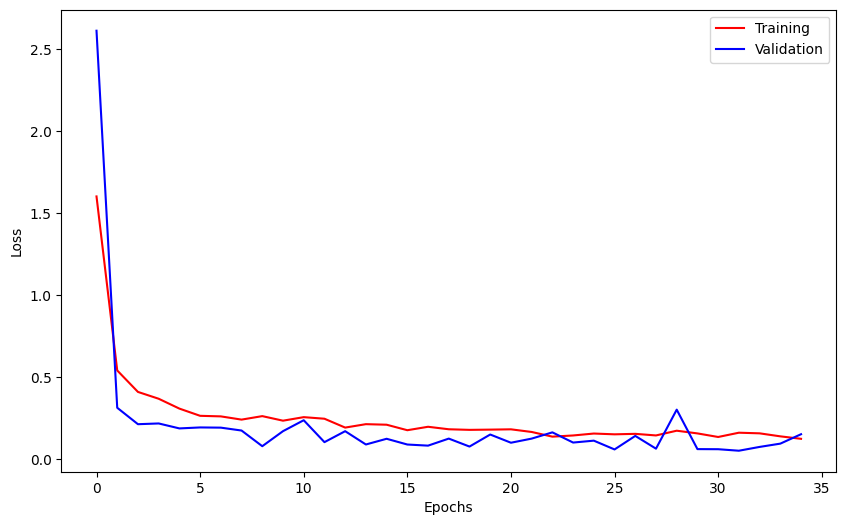

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs, loss, c="red", label="Training")
plt.plot(epochs, val_loss, c="blue", label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

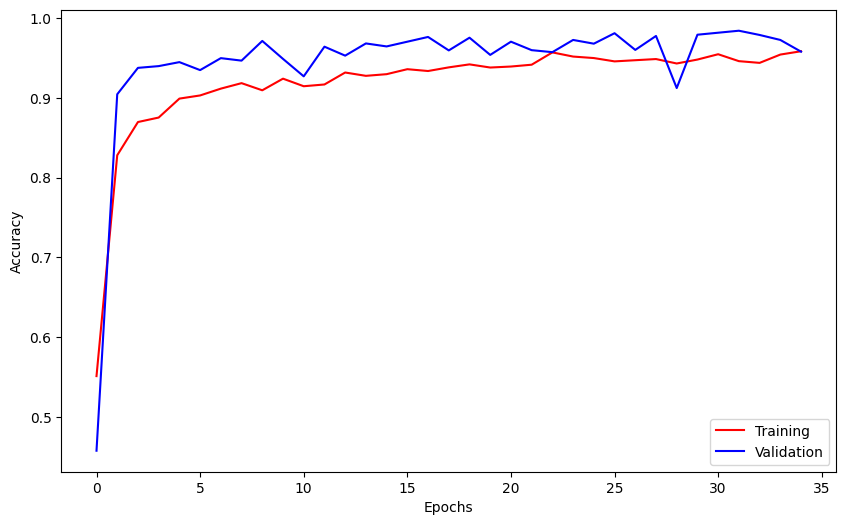

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs, acc, c="red", label="Training")
plt.plot(epochs, val_acc, c="blue", label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Calculate the accuracy of the test dataset
predictions = model.predict(test_data)
predicted_class = np.argmax(predictions, axis=1)
ground_truth = test_data.classes
accuracy = accuracy_score(ground_truth, predicted_class)

116/116 [==============================] - 168s 1s/step


In [ ]:
print(f"the test accuracy is {accuracy}")

the test accuracy is 0.9324871725627869


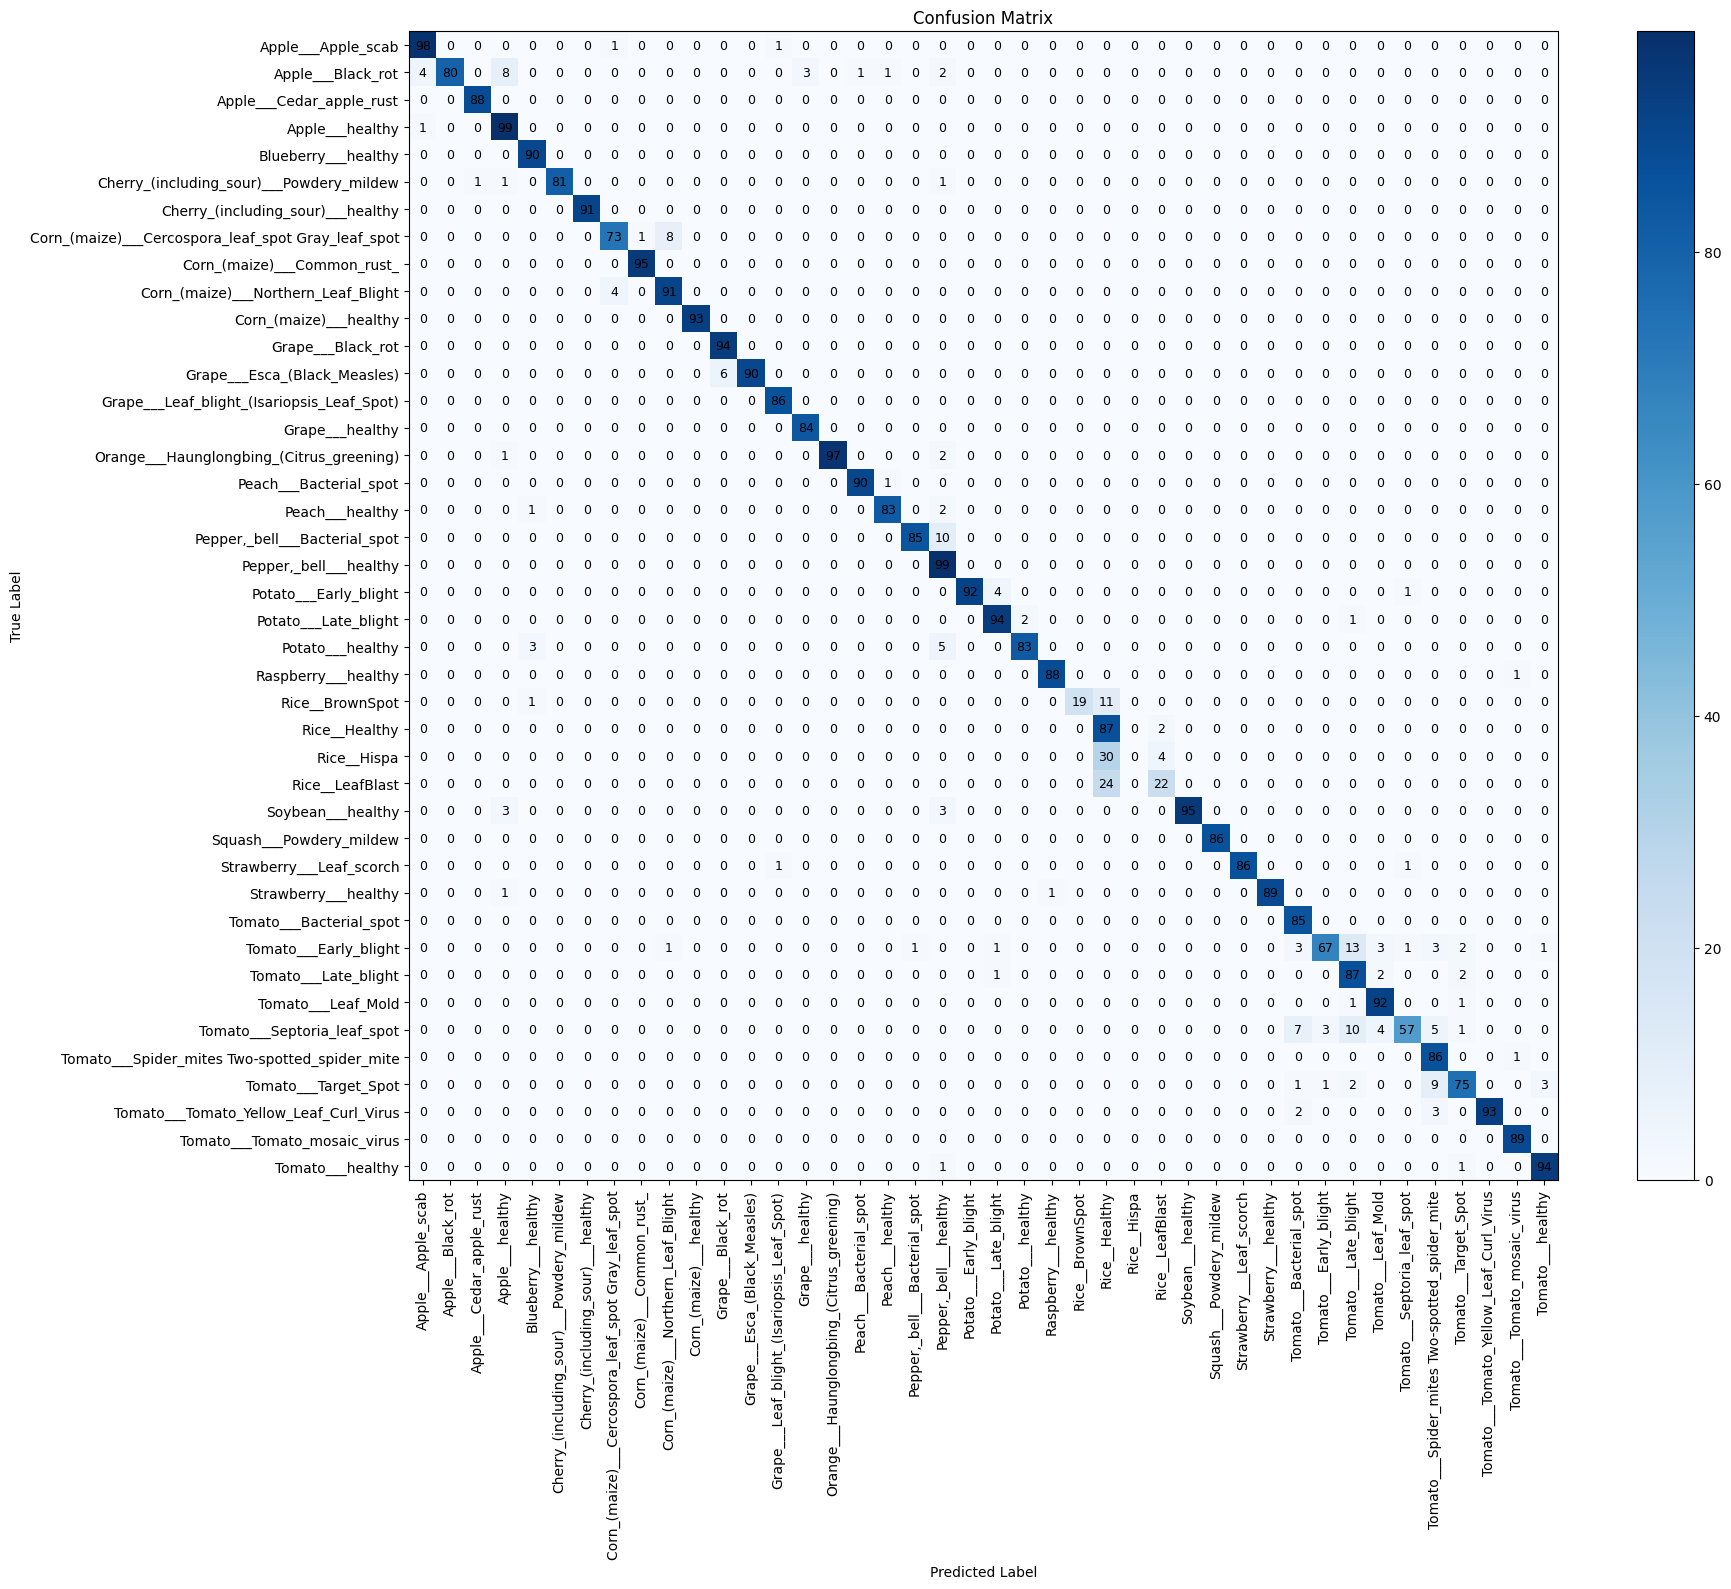

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Example ground truth and predicted labels (replace with your own data)
ground_truth = ground_truth
predicted_labels = predicted_class

# Define the class labels (replace with your own class labels)
class_labels = categories

# Generate confusion matrix
confusion_mat = confusion_matrix(ground_truth, predicted_labels)

# Set figure size
plt.figure(figsize=(20, 16))

# Plot confusion matrix
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=90)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, confusion_mat[i, j], ha='center', va='center', fontsize=9)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.tight_layout()  # Adjust the spacing
plt.show()


## Upload image to predict

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = load_img(path, target_size=target_size)
  x = img_to_array(img)
  x = x / 255.0
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)
  three_max_class = np.argsort(classes)[0][-3:]
  ranks = ['third', 'second', 'most']
  # file_name = path.split("/")[1] 
  print(f"THE CORRECT ANSWER IS {path}")
  for index in reversed(range(3)):
    probability = classes[0][three_max_class[index]]*100
    print(f"The {ranks[index]} likely class: {categories[three_max_class[index]]}")
    print(f"With the probability of : {probability:.2f}%")
  print('\n')

Saving AppleCedarRust3.JPG to AppleCedarRust3.JPG
Saving TomatoYellowCurlVirus3.JPG to TomatoYellowCurlVirus3.JPG
Saving CornCommonRust2.JPG to CornCommonRust2.JPG
Saving CornCommonRust1 (1).JPG to CornCommonRust1 (1).JPG
Saving TomatoEarlyBlight3.JPG to TomatoEarlyBlight3.JPG
Saving TomatoHealthy1.JPG to TomatoHealthy1.JPG
Saving CornCommonRust1.JPG to CornCommonRust1.JPG
Saving AppleScab1.JPG to AppleScab1.JPG
Saving AppleCedarRust1.JPG to AppleCedarRust1.JPG
1/1 [==============================] - 0s 90ms/step
THE CORRECT ANSWER IS AppleCedarRust3.JPG
The most likely class: Apple___Cedar_apple_rust
With the probability of : 99.94%
The second likely class: Tomato___Late_blight
With the probability of : 0.06%
The third likely class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
With the probability of : 0.00%


1/1 [==============================] - 0s 90ms/step
THE CORRECT ANSWER IS TomatoYellowCurlVirus3.JPG
The most likely class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
With the 

## Save model and convert to tflite

In [ ]:
!mkdir savedModel
export_dir = 'savedModel/1'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
import pathlib
tflite_model_file = pathlib.Path('model_2.tflite')
tflite_model_file.write_bytes(tflite_model)

13393024

## Save model to h5

In [ ]:
model.save('model_without_augmentation_last3layertrain_training95_6.h5')

In [ ]:
model = load_model('/content/model_without_augmentation_last3layertrain_training95_6.h5')